In [15]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append('../..')
import pandas as pd
import seaborn as sns
import Model.input_pipeline
from Plots import style
from Model.results import get_df, get_stats, final_plot

# Helper functions

In [16]:
def plus_encode_data(data):
    data = tf.reshape(data, shape=(data.shape[0], -1))
    mean_data = tf.reduce_mean(data, axis=1, keepdims=True)
    need_change = tf.cast(mean_data < 0.5, data.dtype)
    data = data * (1 - 2 * need_change) + need_change
    data = tf.reshape(data, shape=(-1, 32, 32, 1))
    return data   

def sample(num, generator, noise_dim=100):
    random_vector_for_generation = tf.random.normal([num, 1, 1, noise_dim])
    return generator(random_vector_for_generation)

def random_swap(data):
    data = tf.reshape(data, shape = (data.shape[0], -1))
    swap_mask = 2 * (np.random.random(size = (data.shape[0], 1)) > 0.5) - 1
    data = tf.multiply(data, swap_mask)
    data = tf.reshape(data, shape = (-1, 32, 32, 1))
    return data

def load_model_at_T(t, folder):
    generator = tf.keras.models.load_model(f"results/{folder}/{t:.1f}/generator")
    return generator

## Models dictionary

In [17]:
folder = "gan_v2_1"
temps = np.arange(2.0, 3.1, 0.1)
data_list = []

# Compare with monte carlo

## Sampled vs Rounded

In [4]:
model = load_model_at_T(2.2, folder)
data = []
for _ in range(50):
    data.append(sample(1000, model))
data = tf.concat(data, axis=0)
data_sampled = 2 * np.random.binomial(1, data) - 1
data_rounded = 2 * np.round(data) - 1
data_raw = 2 * np.array(data) - 1
df_sampled = get_df(data_sampled)
df_rounded = get_df(data_rounded)
df_raw = get_df(data_raw)

In [5]:
df_raw['method'] = 'raw'
df_rounded['method'] = 'rounded'
df_sampled['method'] = 'sampled'
df = pd.concat([df_raw, df_rounded, df_sampled])

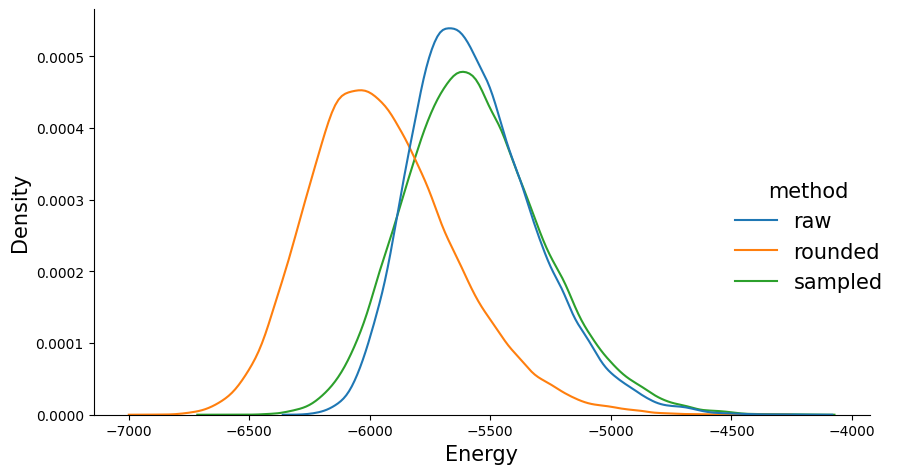

In [6]:
figsize = style.get_figsize('fig')
g = sns.displot(df, x='Energy', hue='method', kind='kde', height = figsize[1], aspect=figsize[0]/figsize[1])  # Adjust plot size
plt.xlabel('Energy')  # Label x-axis
plt.ylabel('Density')  # Label y-axis
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig(f"results/{folder}/plots/sampled_rounded.svg")

## Data Generated

In [18]:
with tf.device('CPU:0'):
    for temp in temps:
        print(f"Temperature: {temp:.2}")
        # Monte Carlo
        trainset_path = f"../../GetData/Python/Data/Data{temp:.2}.tfrecord"
        batch_size = 100
        train_set = Model.input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
        model = load_model_at_T(temp, folder)
        
        sample_list = []
        mc_list = []
        for batch in train_set:
            mc_list.append(batch)
            sample_list.append(sample(batch_size, model))
        
        data_mc = 2 * np.concatenate(mc_list, axis=0) - 1
        spin_prob = np.concatenate(sample_list, axis=0)
        spin_round =  2 * np.round(spin_prob) - 1
        spin_sample =  2 * np.random.binomial(1, spin_prob) - 1

        spin_sample = random_swap(spin_sample)
        spin_round = random_swap(spin_round)

        df_monte_carlo = get_df(data_mc)
        mc_stats = get_stats(df_monte_carlo, temp)
        mc_stats.extend((temp, "Monte Carlo"))
    
        df_sampled = get_df(spin_sample)
        sample_stats = get_stats(df_sampled, temp)
        sample_stats.extend((temp, "GAN sampled"))

        df_rounded = get_df(spin_round)
        round_stats = get_stats(df_rounded, temp)
        round_stats.extend((temp, "GAN rounded"))
    
        data_list.append(mc_stats)
        data_list.append(sample_stats)
        data_list.append(round_stats)

Temperature: 2.0


2024-06-14 15:23:02.922740: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409600000 exceeds 10% of free system memory.
2024-06-14 15:23:03.277069: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409600000 exceeds 10% of free system memory.
2024-06-14 15:23:03.509193: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 204800000 exceeds 10% of free system memory.
2024-06-14 15:23:03.683509: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 204800000 exceeds 10% of free system memory.


Temperature: 2.1


2024-06-14 15:28:01.333560: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 409600000 exceeds 10% of free system memory.


Temperature: 2.2
Temperature: 2.3
Temperature: 2.4
Temperature: 2.5
Temperature: 2.6
Temperature: 2.7
Temperature: 2.8
Temperature: 2.9
Temperature: 3.0


In [19]:
df = pd.DataFrame(data_list, columns=['Magnetization', 'Energy', 'Magnetic susceptibility', 'Heat Capacity', 'Temperature', 'Method'])
df.to_csv(f"results/{folder}/data.csv")

In [20]:
try:
    df_plots = pd.read_csv(f"results/{folder}/data.csv")
except:
    df_plots = df

FileNotFoundError: [Errno 2] No such file or directory: 'results/gan_v2_1/plots/final_plot.svg'

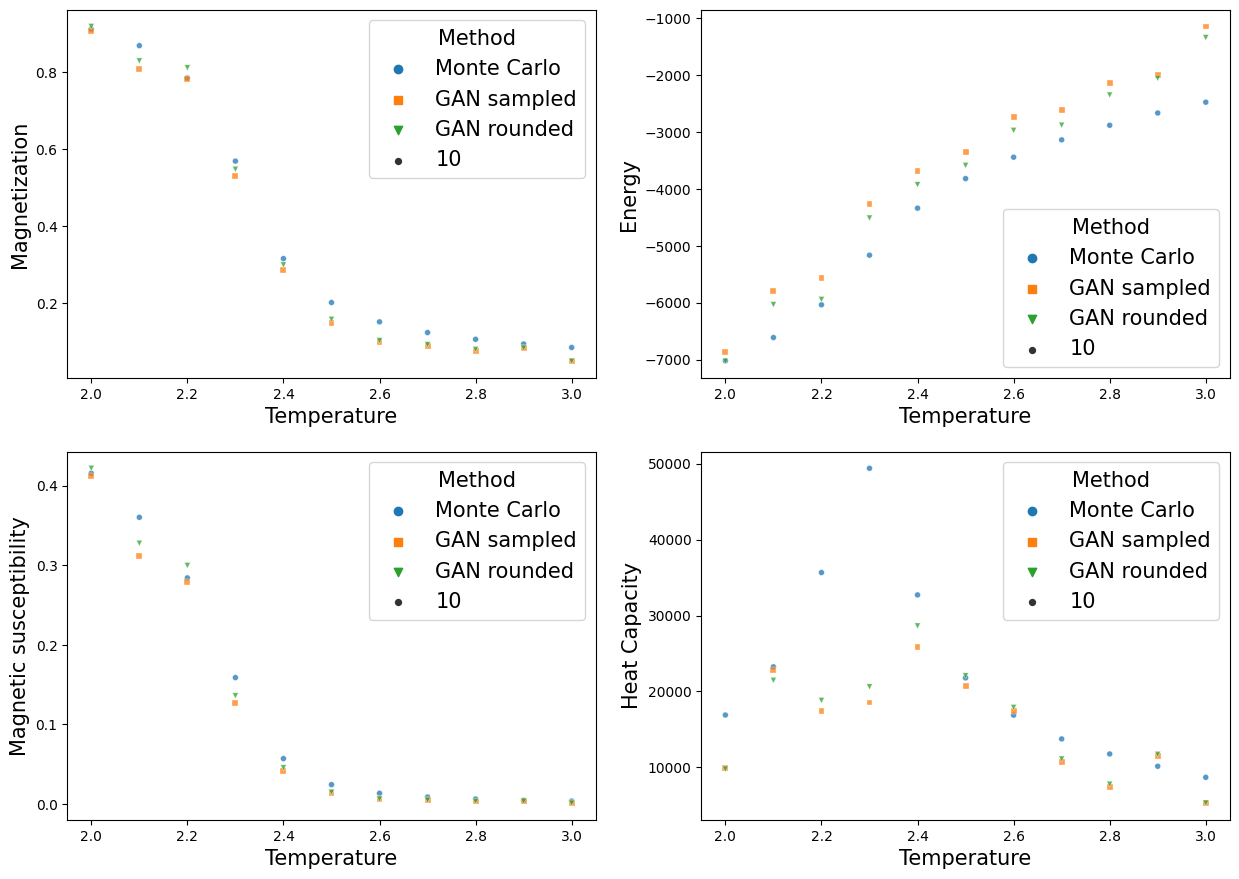

In [21]:
final_plot(df_plots)
plt.savefig(f"results/{folder}/plots/final_plot.svg")

## Examples

In [7]:
models = { temp: load_model_at_T(temp, folder) for temp in temps }
titles = [f"Temperature: {temp:.1f}" for temp in temps]

In [8]:
long_fig = style.get_figsize("long_fig")

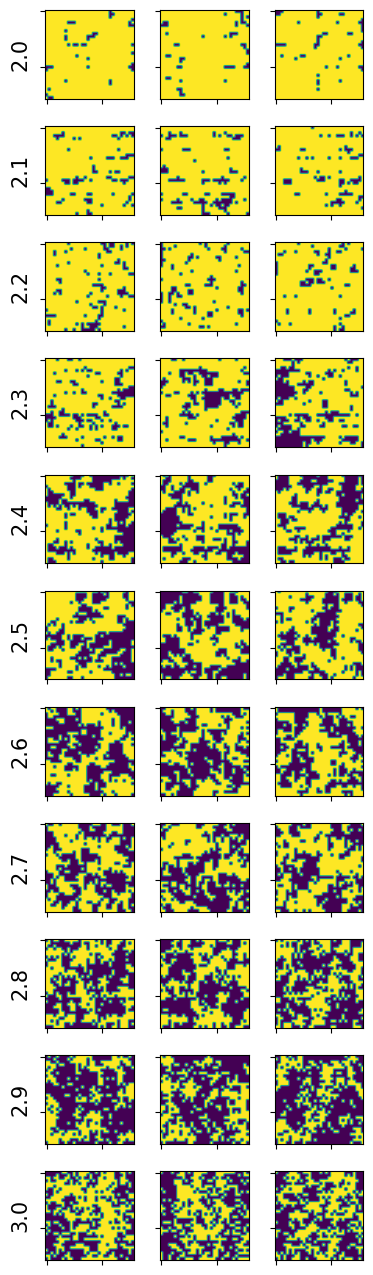

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_samples(titles_temps, folder, name):
    nrpws = len(titles_temps)
    ncols = 3
    fig, axes = plt.subplots(nrows=nrpws, ncols=ncols, figsize=long_fig)
    plt.subplots_adjust(top=0.96)
    for i, ax_row in enumerate(axes):
        title, temp = titles_temps[i]
        ax_row[0].set_ylabel(title.split()[-1], rotation=90, size=15)
        predictions = sample(5, models[temp])
        for j, ax in enumerate(ax_row):
            ax.yaxis.set_ticklabels([])
            ax.xaxis.set_ticklabels([])
            spins = np.random.binomial(1, predictions[j, :, :])
            ax.imshow(spins, vmin=0, vmax=1)
    plt.tight_layout()
    plt.savefig(f"results/{folder}/plots/samples_{name}.svg")

titles_temps = list(zip(titles, temps))
plot_samples(titles_temps, folder, "all")
